In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import pdb
import copy
import math

from FlowModels import *
from SOBI import *

from sklearn import cluster, datasets, mixture

import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

%matplotlib inline

### Data generation

In [2]:
import scipy as sp
from scipy import signal

np.random.seed(0)
n_samples = 4000
time = np.linspace(0, 8, n_samples)

s1 = np.sin(2 * time)  # Signal 1 : sinusoidal signal

irregular_time = [0]
for _ in time[1:]:
    irregular_time.append(irregular_time[-1] + np.random.randint(5) + 1)
    
irregular_time = np.array(irregular_time) / n_samples * 8

s2 = np.sign(np.sin(3 * irregular_time))  # Signal 2 : square signal

irregular_time = [0]
for _ in time[1:]:
    irregular_time.append(irregular_time[-1] + np.random.randint(5) + 1)
    
irregular_time = np.array(irregular_time) / n_samples * 8

s3 = signal.sawtooth(2 * np.pi * irregular_time)  # Signal 3: saw tooth signal
s4 = np.arange(-1, 1, 2/n_samples)

S = np.c_[s1, s2, s3, s4]
S += 0.2 * np.random.normal(size=S.shape)  # Add noise

S /= S.std(axis=0)  # Standardize data
S = (S - S.min(axis=0, keepdims=True)) / (S.max(axis=0, keepdims=True) - S.min(axis=0, keepdims=True))  # Standardize data
# Mix data
A = np.array([[1, 1, 1, 1], [0.5, 2, 1.0, 0.5], [1.5, 1.0, 2.0, 1.5], [-0.5, 1, 0.2, 0.5]])  # Mixing matrix
X = np.dot(S, A.T)  # Generate observations

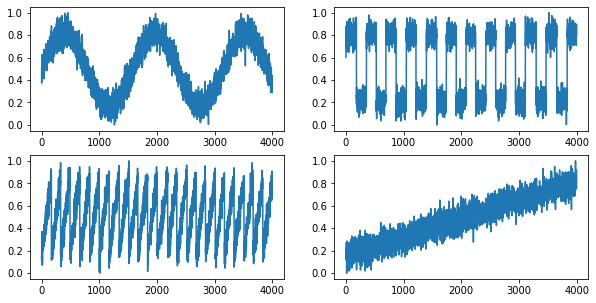

In [3]:
plt.figure(figsize=(10,5))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.plot(S[:, i])

### Non-linear mixing with a randomly initialized flow-based model

In [4]:
D = 4
NN = lambda: nn.Sequential(nn.Linear(D//2, D))

mixture = FlowModel(D, NN, 10).to(device)

S = torch.FloatTensor(S).to(device)
X = torch.FloatTensor(X).to(device)

previous_loss = torch.zeros(X.size(0)).to(device)
    
X_nl = mixture.to_embedding(S, previous_loss)[0].cpu().detach().numpy()

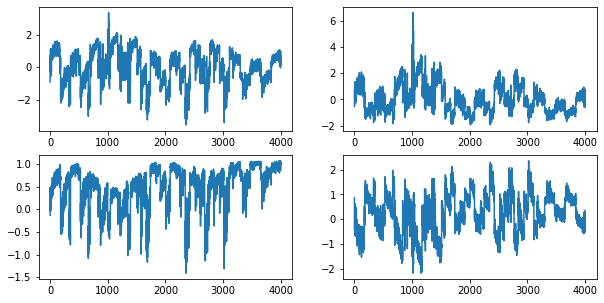

In [5]:
plt.figure(figsize=(10,5))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.plot(X_nl[:, i])

### Test linear ICA to see that it fails

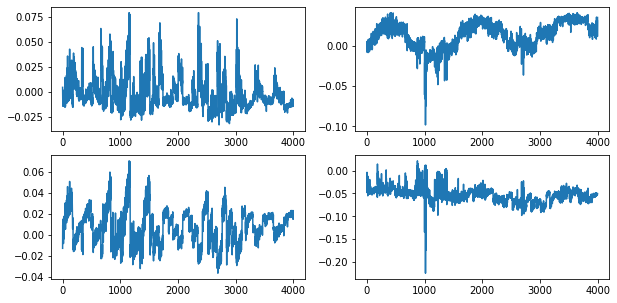

In [7]:
S_estimated, _ = ICA(X_nl.T, lags=50)
S_estimated = S_estimated.T

plt.figure(figsize=(10,5))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.plot(S_estimated[:, i])

In [8]:
previous_loss = torch.zeros(X.size(0)).to(device)
results= []

for _ in range(20):
    mixture = FlowModel(D, NN, 10).to(device)
    X_nl = mixture.to_embedding(S, previous_loss)[0].cpu().detach().numpy()
    S_estimated, _ = ICA(X_nl.T, lags=50)
    results.append(np.abs(np.corrcoef(S.detach().numpy().T, S_estimated)[4:, :-4]).max(1).mean())
    
print(np.mean(results), np.std(results))

0.5731683624448096 0.054842074124919586


We see that the mixing is effectively **not** linearly identifiable. 

### Unmixing with slow-FBM

We first define the flow-based unmixing model

In [9]:
class FlowModel(LayerList, nn.Module):
    
    """ **FlowModel**: example of flow-based model architecture class.
    
        Parameters
        ----------
            * D: dimension of the input
            * NN: neural networks used in the **AffineCoupling**
            * depth: depth of the flow-based model (number of FlowLayers)
            * trainable_variance: possibility to learn the variance parameters of the increment Gaussian distribution
                                  We remind that the theoretical results assume infinte data.
                                  In this toy example, we have not infinte data at all.
                                  The trainable variance for increment distribution gives more robust results in low data setup.
    """
    
    def __init__(self, D, NN, depth=1, trainable_variance=True):
        super(FlowModel, self).__init__()
        self.D = D
        self.depth = depth
        
        if trainable_variance:
            self.scales = nn.ParameterList([nn.Parameter(torch.ones(D), requires_grad=(i!=0)) for i in range(2)])
        else:
            self.scales = nn.ParameterList([nn.Parameter(torch.ones(D), requires_grad=False) for i in range(2)])
        
        layers = []
        for d in range(depth):
            shuffled_layer = Shuffle(D)
            layers.append(shuffled_layer)
            layers.append(ActivationNormalization(D))
            layers.append(AffineCoupling(D, NN()))
            layers.append(shuffled_layer)
            layers.append(ActivationNormalization(D))
            layers.append(AffineCoupling(D, NN()))
        
        layers.append(Linear(D))
        self.layers = nn.ModuleList(layers)

Instanciate the unmixing model

In [10]:
D = 4

NN = lambda: nn.Sequential(nn.Linear(D//2, 16), nn.LeakyReLU(), 
                           nn.Linear(16, D))

flowModel = FlowModel(D, NN, 12)
flowModel = flowModel.to(device)
optimizer = torch.optim.Adam(list(flowModel.parameters()), lr=1e-3)

In [11]:
X_nl = torch.FloatTensor(X_nl).to(device)
previous_loss = torch.zeros(X_nl.size(0)).to(device)
index = np.arange(X_nl.shape[0])

The previous loss is specific to the Abstract Class design of the FlowBased model.

In [12]:
from torch.distributions.multivariate_normal import MultivariateNormal

for t in range(1500):
    
    optimizer.zero_grad()
    
    index = index[::-1]
    
    x = X_nl[list(index)]
    
    previous_loss = torch.zeros(x.size(0)).to(device)
    z, logprob = flowModel.to_embedding(x, previous_loss)
    
    loss = -logprob.mean()
    
    for i, s in enumerate(flowModel.scales):
        s = s**2
        m = MultivariateNormal(torch.zeros(1, D).to(device), torch.diag(s))
        if i == 0:
            z_lag = z
        else:
            z_lag = z[i:] - z[:-i]
        loss -= m.log_prob(z_lag).mean()
        
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        flowModel.layers[-1].W.div_(torch.norm(flowModel.layers[-1].W))
    
    if t % 10 == 0:
        print('iter %s:' % t, 'loss = %.3f' % loss)

iter 0: loss = 11.373
iter 10: loss = 17.968
iter 20: loss = 16.198
iter 30: loss = 15.049
iter 40: loss = 14.327
iter 50: loss = 13.795
iter 60: loss = 13.358
iter 70: loss = 12.982
iter 80: loss = 12.678
iter 90: loss = 12.407
iter 100: loss = 12.182
iter 110: loss = 11.987
iter 120: loss = 11.803
iter 130: loss = 11.634
iter 140: loss = 11.469
iter 150: loss = 11.318
iter 160: loss = 11.192
iter 170: loss = 11.045
iter 180: loss = 10.932
iter 190: loss = 10.805
iter 200: loss = 10.701
iter 210: loss = 10.594
iter 220: loss = 10.503
iter 230: loss = 10.402
iter 240: loss = 10.311
iter 250: loss = 10.220
iter 260: loss = 10.152
iter 270: loss = 10.069
iter 280: loss = 9.993
iter 290: loss = 9.904
iter 300: loss = 9.836
iter 310: loss = 9.762
iter 320: loss = 9.688
iter 330: loss = 9.628
iter 340: loss = 9.548
iter 350: loss = 9.488
iter 360: loss = 9.419
iter 370: loss = 9.352
iter 380: loss = 9.305
iter 390: loss = 9.236
iter 400: loss = 9.200
iter 410: loss = 9.149
iter 420: loss = 

Plot the estimated sources

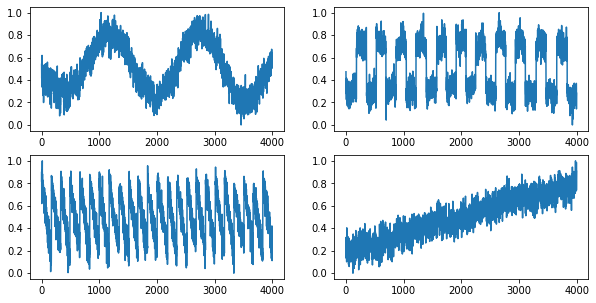

In [13]:
z, logprob = flowModel.to_embedding(X_nl, previous_loss)
S_estimated, _ = ICA(z.detach().numpy().T, lags=100)

m = S_estimated.min(1, keepdims=True)
M = S_estimated.max(1, keepdims=True)
S_estimated = ((S_estimated - m) / (M - m)).T

corr = np.corrcoef(S.detach().numpy().T, S_estimated.T)[4:, :-4]
max_cor = np.argmax(np.abs(corr), axis=0)

plt.figure(figsize=(10,5))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.plot(S_estimated[:, max_cor[i]])

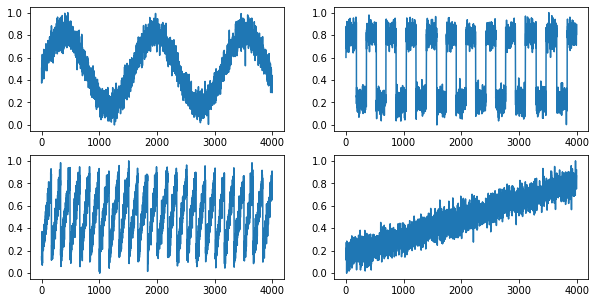

In [14]:
plt.figure(figsize=(10,5))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.plot(S[:, i])

Correlation with the true sources

In [15]:
np.corrcoef(S.detach().numpy().T, S_estimated.T)[4:, :-4]

array([[-0.07047043, -0.03649786,  0.01696447,  0.97434573],
       [-0.01237649, -0.00800188, -0.97571618, -0.02871617],
       [ 0.01785423, -0.9699717 , -0.008193  , -0.02646911],
       [-0.96480754,  0.00768215,  0.00469692, -0.03816901]])

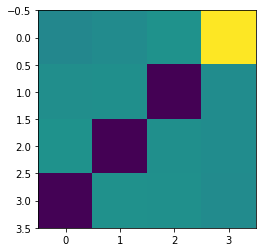

In [16]:
plt.imshow(np.corrcoef(S.detach().numpy().T, S_estimated.T)[4:, :-4])

Mean absolute correlation

In [17]:
np.abs(np.corrcoef(S.detach().numpy().T, S_estimated.T)[4:, :-4]).max(1).mean()

0.971210287852238